In [72]:
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

from category_encoders import OneHotEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE

In [73]:
# read the data sets
df = pd.read_csv('../data/clean_HR_Analytics3.csv')
df.head()

,Age,Attrition,DistanceFromHome,EducationField,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MaritalStatus,MonthlyIncome,OverTime,StockOptionLevel,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsWithCurrManager
0,41,Yes,1,Life Sciences,2,3,2,4,Single,5993,Yes,0,8,6,4,5
1,49,No,8,Life Sciences,3,2,2,2,Married,5130,No,1,10,10,7,7
2,37,Yes,2,Other,4,2,1,3,Single,2090,Yes,0,7,0,0,0
3,33,No,3,Life Sciences,4,3,1,3,Married,2909,Yes,0,8,8,7,0
4,27,No,2,Medical,1,3,1,2,Married,3468,No,1,6,2,2,2


#### Split

In [67]:
# vertical split
target = "Attrition"
X = df.drop(columns=target)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Build

In [14]:
pipe = make_pipeline(
    OrdinalEncoder(),
    MinMaxScaler(),
    RandomForestClassifier(random_state=42)
)

In [15]:
params = {
    "randomforestclassifier__n_estimators": range(30, 100, 10),
    "randomforestclassifier__max_depth": range(10, 50, 5)
}

In [16]:
model = GridSearchCV(
    pipe,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 5),
                         'randomforestclassifier__n_estimators': range(30, 100, 10)},
             verbose=1)

In [17]:
# Train model
model.fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 5),
                         'randomforestclassifier__n_estimators': range(30, 100, 10)},
             verbose=1)

In [19]:
# Extract the best hyperparameters
model.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__n_estimators': 80}

#### Evaluate

In [20]:
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print("Training Accuracy: ", round(train_acc, 2))
print("Test Accuracy: ", round(test_acc, 2))

Training Accuracy:  0.97
Test Accuracy:  0.86


##### Plot Confusion Matrix

In [21]:
# generate the confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[249,   6],
       [ 35,   4]])

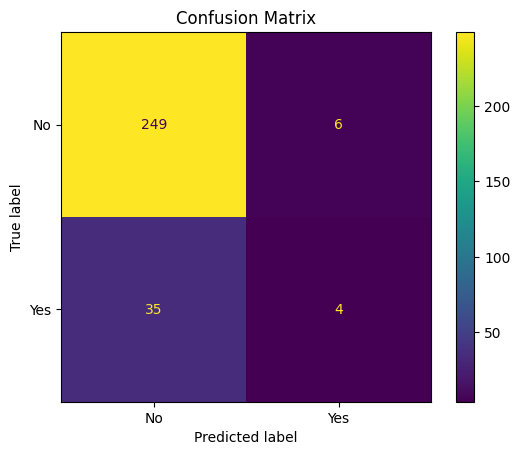

In [22]:
#Create the ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# plot the confusion matrix
cm_display.plot()  
plt.title("Confusion Matrix");
plt.savefig('../reports/confusion_matrix_RF.jpg')

#### Communicate

In [24]:
# get feature names
features = model.best_estimator_.named_steps["ordinalencoder"].get_feature_names_out()
# Extract the importances from model
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
# create a series
features_imp = pd.Series(importances, index=features).sort_values()

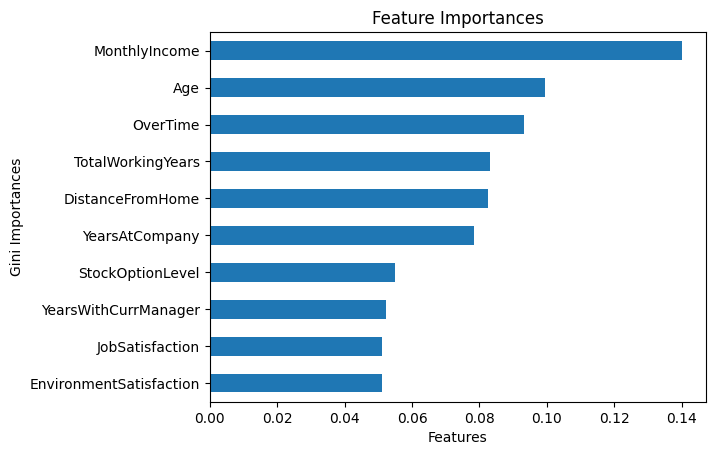

In [25]:
features_imp.tail(10).plot(kind="barh")
plt.xlabel("Features")
plt.ylabel("Gini Importances")
plt.title("Feature Importances");

#### Save the Model

In [12]:
import joblib
timestamp = pd.Timestamp.now().replace(microsecond=0).isoformat()
file_path = os.path.join('../models', f'{timestamp}_RF.joblib')
with open(file_path, 'wb') as f:
    pickle.dump(model, f)